## Intro

To set up you need to download the LISA dataset here:
https://www.kaggle.com/mbornoe/lisa-traffic-light-dataset/notebooks




In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from glob import glob

import urllib.request
import requests


model_file = "http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz"

In [33]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
model_path = "./"
PATH_TO_CKPT = model_path + MODEL_NAME + '/frozen_inference_graph.pb'




def download_model():
    import six.moves.urllib as urllib
    import tarfile
    
    model_file_url = DOWNLOAD_BASE + MODEL_FILE + MODEL_FILE
    
    r = urllib.request.urlopen(model_file_url)
    with open(MODEL_FILE, "wb") as f:
        for chunk in r.raw.stream(1024, decode_content=False):
            if chunk:
                f.write(chunk)

                

In [34]:
model = download_model()

In [26]:
DOWNLOAD_BASE + MODEL_FILE + MODEL_FILE

'http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gzssd_mobilenet_v1_coco_11_06_2017.tar.gz'

In [37]:
PATH_TO_CKPT = model_path + MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_CKPT

'./ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'

In [47]:
def load_graph():
    
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph


In [49]:
detection_graph = load_graph()


In [52]:
def select_boxes(boxes, classes, scores, score_threshold=0, target_class=10):
    """

    :param boxes:
    :param classes:
    :param scores:
    :param target_class: default traffic light id in COCO dataset is 10
    :return:
    """

    sq_scores = np.squeeze(scores)
    sq_classes = np.squeeze(classes)
    sq_boxes = np.squeeze(boxes)

    sel_id = np.logical_and(sq_classes == target_class, sq_scores > score_threshold)

    return sq_boxes[sel_id]

In [53]:
class TLClassifier(object):
    def __init__(self):

        self.detection_graph = load_graph()
        self.extract_graph_components()
        self.sess = tf.Session(graph=self.detection_graph)

        # run the first session to "warm up"
        dummy_image = np.zeros((100, 100, 3))
        self.detect_multi_object(dummy_image,0.1)
        self.traffic_light_box = None
        self.classified_index = 0

    def extract_graph_components(self):
        # Definite input and output Tensors for detection_graph
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')
    
    def detect_multi_object(self, image_np, score_threshold):
        """
        Return detection boxes in a image

        :param image_np:
        :param score_threshold:
        :return:
        """

        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.

        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})

        sel_boxes = select_boxes(boxes=boxes, classes=classes, scores=scores,
                                 score_threshold=score_threshold, target_class=10)

        return sel_boxes

In [54]:
tlc=TLClassifier()


In [55]:
tlc

In [56]:
from PIL import Image

In [79]:
%time
test_file = "samples/daySequence2--06683.jpg"


im = Image.open(test_file)
image_np = np.asarray(im)



CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 11.9 µs


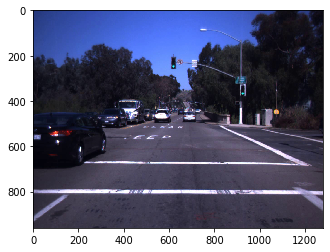

In [80]:
plt.imshow(image_np)

In [81]:
def crop_roi_image(image_np, sel_box):
    im_height, im_width, _ = image_np.shape
    (left, right, top, bottom) = (sel_box[1] * im_width, sel_box[3] * im_width,
                                  sel_box[0] * im_height, sel_box[2] * im_height)
    cropped_image = image_np[int(top):int(bottom), int(left):int(right), :]
    return cropped_image

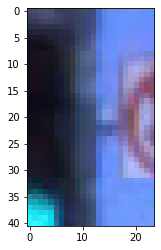

In [84]:
boxes=tlc.detect_multi_object(image_np, score_threshold=0.2)
cropped_image=crop_roi_image(image_np, boxes[0])
plt.imshow(cropped_image)

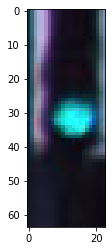

In [85]:
cropped_image=crop_roi_image(image_np, boxes[1])
plt.imshow(cropped_image)